<a href="https://colab.research.google.com/github/trishaa4144/cmsc320-final/blob/main/CMSC320_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rat Sightings in New York City

### Fall 2024 Data Science Project

### Your name(s): Lasya Muthyam, Sriya Peddinti, Trisha Anand, Christina Xu

### Contributions
Trisha worked on parts A-H. Specifically, she worked on planning, exploratory data analysis, visualization, and statistical tests such as ANOVA test across boroughs for the rat sightings dataset. Additionally, she contributed to planning ML model development, and putting together the final writeup & insights.

Sriya worked on the dataset curation and preprocessing, data exploration, and visualization of the income dataset. This involved cleaning and preparing the income and the zipcode-borough dataset. She created a visualization with this merged dataset as a part of data exploration. She also worked to combine and clean the new merged income and rat cleaning dataset to prepare it for ML training.

Lasya: I actively contributed to all parts A-H. Specifically, I worked on cleaning and analyzing the Rat Sightings dataset and then designed, trained, and created visualizations/metrics for the random forest classifier model that predicts the concentration of rat sightings in an area given the latitude, longitude, location type, Average Income (Dollars), total number of households, and seasonality.

Christina worked on dataset preprocessing and EDA for the rat sightings and population density datasets, which revealed a non-significant correlation between the number of rat sightings and population density. She worked on D-F to perform K-Means Clustering to cluster rat sightings based on longitude, latitude, year, and average income. She visualized the elbow method using distortions, silhouette plots, and the clusters after PCA and calculated the corresponding metrics.

# Introduction

Researching rat sightings in New York City is crucial for addressing pressing safety and hygiene concerns that impact public health and urban living conditions. Rats are known carriers of diseases such as leptospirosis, hantavirus, and Tularemia, which can pose significant risks to human health. By analyzing data on rat sightings, we can identify hotspots where infestations are most prevalent, leading to targeted interventions and preventive measures. The chosen Rat Sightings dataset contains data points on over 250k+ rat sightings on 35+ parameters, including time, location, and neighborhoods, providing us with a rich dataset of information on rat populations in New York City.

# Data Curation & Sources

**Main Dataset**: [Rat Sightings Dataset](https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe/about_data): A dataset containing rat sightings (311 service requests) in New York City from 2010 till September 17, 2024, which came from the NYC Open Data website.

**Supplementary Datasets**:
*   [Income dataset](https://www.kaggle.com/datasets/claygendron/us-household-income-by-zip-code-2021-2011?resource=download): This dataset contains US household income by zip code from 2021-2011, which is from a US census dataset that we found on Kaggle.
*   [Zipcode-Borough](https://data.ny.gov/Government-Finance/New-York-State-ZIP-Codes-County-FIPS-Cross-Referen/juva-r6g2/data): This dataset contains New York State ZIP codes, counties, and FIPS codes from the New York State Office of Information Technology Services.
*   [Population Density](https://simplemaps.com/data/us-zips): Population of each ZIP, taken from US census data, and found on the simplemaps website.

# Exploratory Data Analysis

## Part 1: Initial Data Cleaning: Rat Sightings

We will start by cleaning our dataset to remove null values, and narrow our dataset down to certain columns.

First, we import our dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

We filter out unnecessary/sparse columns like "Taxi Pick Up Location", "Bridge Highway Name", etc. This way, we cut the number of columns from 38 to 7 columns.

We are deciding to look at the following important columns: Created Date, Location Type, Incident Zip, Community Board, Borough, Latitude, Longitude.


In [2]:
# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]

Next, we remove Boroughs that are "Unspecified" from the dataframe.

In [3]:
# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']
df.reset_index(drop=True, inplace=True)

Next, drop NA values and duplicates from the dataset.

In [4]:
df.dropna(subset=['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude'], inplace=True)

Finally, we will map Location Types to non-duplicate category classifications.

In [5]:
# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()

# Define mapping for residential categories
residential_mapping = {
    'Single Room Occupancy (SRO)': 'Single',
    '1-2 Family Dwelling': '1-2 Family Apartment',
    '1-2 FamilyDwelling': '1-2 Family Apartment',
    '3+ Family Apt. Building': '3+ Family',
    '3+ Family Apartment Building': '3+ Family',
    '3+ Family Apt.': '3+ Family',
    '3+Family Apt.': '3+ Family',
    '3+ Family Apt': '3+ Family',
    '1-3 Family Dwelling': '1-3 Family Dwelling',
    '1-3 Family Mixed Use Building': '1-3 Family Mixed',
    '1-2 Family Mixed Use Building': '1-2 Family Mixed',
    '3+ Family Mixed Use Building': '3+ Family Mixed',
    'Private House': 'Private House',
    'Apartment': 'Apartment',
    'Residential Property': 'Residential Property'
}

# Apply mapping to the 'Location Type' column for residential data
df['Location Type'] = df['Location Type'].replace(residential_mapping)

Now that we have done the initial cleaning of our dataset, lets proceed forward and visualize how rat sightings compare across location, time, and income level.

First, let's visualize how rat sightings compare across Zip Codes

## Part 2: General EDA & Characteristics of Data


Next, we will continue cleaning our dataset while getting key insights on our data results.

### Main Characteristics

In [6]:
# Rough overview of features we want to consider (main characteristics of dataset)

# All boroughs and number of sightings in each
boroughs = df.groupby(['Borough']).groups.keys()
print("*** Boroughs ***")
print(list(boroughs))
mode = df.groupby(['Borough']).count()['Created Date']
print(mode)

*** Boroughs ***
['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
Borough
BRONX            45183
BROOKLYN         92179
MANHATTAN        65173
QUEENS           38457
STATEN ISLAND     9778
Name: Created Date, dtype: int64


There are 5 boroughs from which rat sightings were reported (as there are 5 boroughs in New York City). We see from the counts of sightings per each borough that Brooklyn has the highest count, 91100, and Staten Island has the fewest, 9684.

In [7]:
# All location types and number of sightings in each
location_type = df.groupby(['Location Type']).groups.keys()
print("*** Location Type ***")
print(list(location_type))
mode = df.groupby(['Location Type']).count()['Created Date']
print(mode)

*** Location Type ***
['1-2 Family Apartment', '1-2 Family Mixed', '1-3 Family Dwelling', '1-3 Family Mixed', '3+ Family', '3+ Family Mixed', 'Abandoned Building', 'Apartment', 'Beach', 'Building (Non-Residential)', 'Cafeteria - Public School', 'Catch Basin/Sewer', 'Catering Service', 'Commercial Building', 'Commercial Property', 'Construction Site', 'Day Care/Nursery', 'Government Building', 'Grocery Store', 'Ground', 'Hospital', 'Office Building', 'Other', 'Other (Explain Below)', 'Parking Lot/Garage', 'Private House', 'Public Garden', 'Public Stairs', 'Residence', 'Residential Building', 'Residential Property', 'Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Retail Store', 'School', 'School/Pre-School', 'Single', 'Store', 'Street Area', 'Street Fair Vendor', 'Summer Camp', 'Vacant Building', 'Vacant Lot', 'Vacant Lot/Property']
Location Type
1-2 Family Apartment           47176
1-2 Family Mixed                4124
1-3 Family Dwelling               15
1-3 Family Mixed                   

There are 44 types of locations in the reported rat sightings, ranging from 1 to 104476 sightings in a location type. The location types with only 1 sighting are potential outliers--this includes Public School Cafeteria, Catering Service, Private House, Retail Store, and Street Fair Vendor. From these categories, it's possible that there is bias influencing the low count of reported sightings. For instance, people may feel less inclined to report a rat sighting at a private event or venue.

In [8]:
# All zip codes and number of sightings in each (in descending order)
zip_codes = df.groupby(['Incident Zip']).groups.keys()
print("*** Incident Zip Code ***")
print(list(zip_codes))
# print top 10 counts per zip codes
zip_code_dict = {}
for key in zip_codes:
  zip_code_dict[key] = len(df[df['Incident Zip'] == key])
print("\n(Incident Zip Code , Count) in descending order:")
zip_code_dict = sorted(zip_code_dict.items(), key=lambda item: item[1], reverse=True)
print(zip_code_dict)

*** Incident Zip Code ***
[83.0, 10000.0, 10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10007.0, 10009.0, 10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0, 10018.0, 10019.0, 10020.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0, 10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0, 10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0, 10040.0, 10041.0, 10044.0, 10045.0, 10048.0, 10065.0, 10069.0, 10075.0, 10111.0, 10112.0, 10115.0, 10118.0, 10119.0, 10120.0, 10121.0, 10128.0, 10151.0, 10162.0, 10174.0, 10178.0, 10271.0, 10278.0, 10280.0, 10282.0, 10301.0, 10302.0, 10303.0, 10304.0, 10305.0, 10306.0, 10307.0, 10308.0, 10309.0, 10310.0, 10312.0, 10314.0, 10451.0, 10452.0, 10453.0, 10454.0, 10455.0, 10456.0, 10457.0, 10458.0, 10459.0, 10460.0, 10461.0, 10462.0, 10463.0, 10464.0, 10465.0, 10466.0, 10467.0, 10468.0, 10469.0, 10470.0, 10471.0, 10472.0, 10473.0, 10474.0, 10475.0, 11001.0, 11004.0, 11040.0, 11101.0, 11102.0, 11103.0, 11104.0, 11105.0, 1110

Considering the number of sightings per zip code, we can observe that the zip code with the greatest number of sightings is in Brooklyn, which is the borough with the greatest number of sightings. Aside from the zip code with the second-highest number of sightings belonging to Manhattan, the other zip codes in the top 5 all belong to Brooklyn.

In [9]:
# Rows, columns
print("(Rows, columns):")
print(df.shape)

(Rows, columns):
(250770, 7)


### Visualizing Residential & Non-Residential Rat Sightings Data

Let's next observe the relationship between rat sightings in residential and non-residential areas. From this visualization, we can see that the proportion of residential rat sightings is much higher than non-residential sightings. This provides us with insight into the makeup of our dataset.

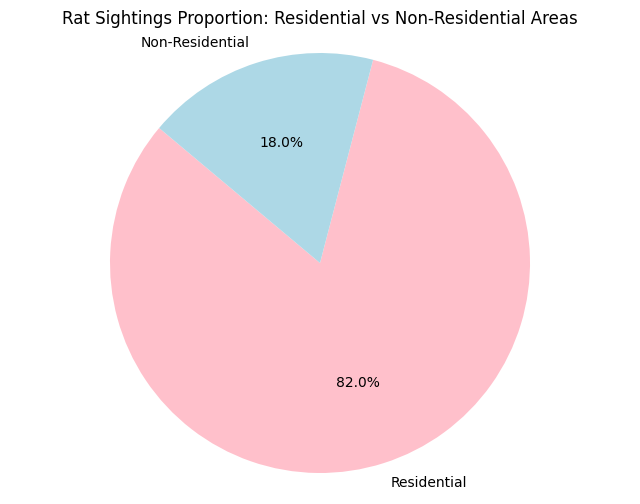

In [10]:
# Create the residential and non-residential DataFrames
residential_df = df[df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = df[~df['Location Type'].isin(residential_mapping.values())]
nonresidential_df = nonresidential_df[~nonresidential_df['Location Type'].isin(['Other', 'Other (Explain Below)'])]

# Basic Data Exploration - residential vs nonresidential pie chart
residential_count = residential_df.shape[0]
nonresidential_count = nonresidential_df.shape[0]

# Data for the pie chart
labels = ['Residential', 'Non-Residential']
sizes = [residential_count, nonresidential_count]
colors = ['pink', 'lightblue']

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Rat Sightings Proportion: Residential vs Non-Residential Areas')
# Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.axis('equal')
plt.show()

Next, let's take a look at the geographic density of rat sightings using our Latitude and Longitude data along with frequencies. It can be seen from the map that there are high concentrations of rat sightings located within Manhattan and Brooklyn in particular.

Insights: Over-representation
Residential locations had a significantly higher number of reported rat sightings compared to non-residential areas. This is evident from the data: the residential_df contains 175,031 rows, while the nonresidential_df has only 38,665 rows. While this could indicate that rat sightings are more frequent in residential areas, the data may be skewed. People might be more inclined to report rat sightings in private or residential spaces than in non-residential areas or public streets. We thus, need to further investigate why there is such a high discrepency in the number of sightings.

### Visualizing Location of Rat Sightings

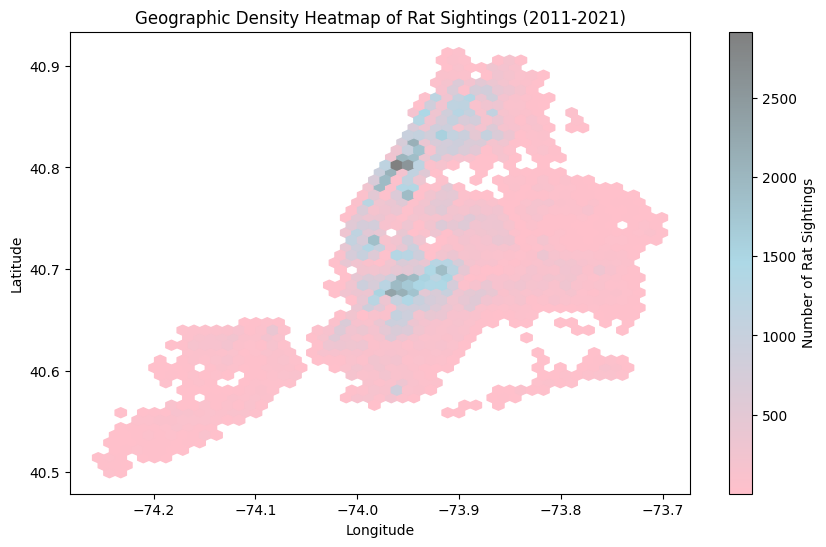

In [11]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["pink", "lightblue", "grey"])
plt.figure(figsize=(10, 6))
plt.hexbin(df['Longitude'], df['Latitude'], gridsize=50, cmap=cmap, mincnt=1)
plt.colorbar(label='Number of Rat Sightings')
plt.title('Geographic Density Heatmap of Rat Sightings (2011-2021)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Part 3: Rat Sightings over Time & Seasons

In this section, we explore the patterns of rat sightings over time  by extracting relevant date information from our dataset and visualizing these trends. We will focus on how rat sightings vary across different months and perform a statistical comparison between seasons—specifically, winter and summer.


Extract the month, week, and day from the dates in the dataset.

In [12]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month, week, and day information
# df['Year'] = df['Created Date'].dt.year
df['Month'] = df['Created Date'].dt.month
df['Week'] = df['Created Date'].dt.isocalendar().week
df['Day'] = df['Created Date'].dt.day

# Check the updated dataframe
print(df[['Created Date', 'Month', 'Week', 'Day']].head())

         Created Date  Month  Week  Day
0 2024-05-31 00:10:00      5    22   31
1 2024-06-01 15:01:00      6    22    1
2 2024-06-06 10:08:00      6    23    6
3 2024-06-25 11:34:00      6    26   25
4 2024-06-27 10:48:00      6    26   27


### Visualizing Rat sightings over Months

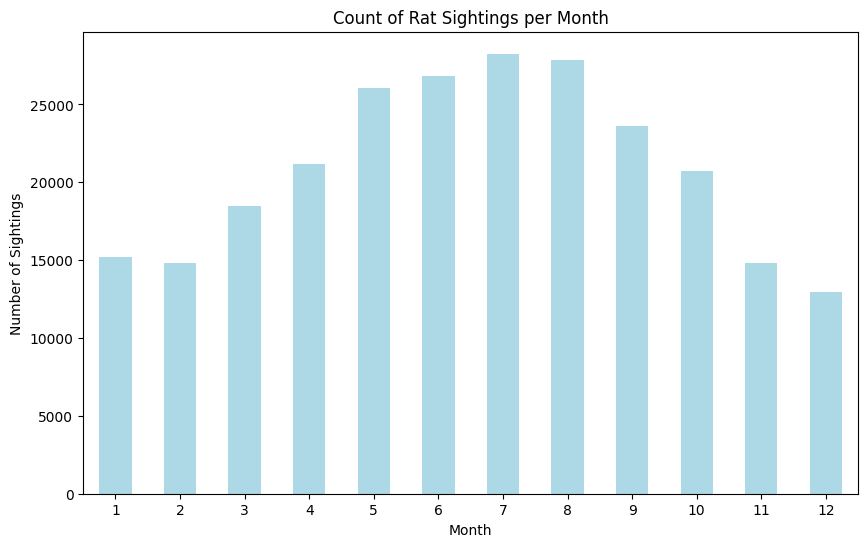

In [13]:
# Count rat sightings per month
rat_sightings_by_month = df['Month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_month.plot(kind='bar', color='lightblue')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.show()

### Visualizing Rat Sightings over Month-Years


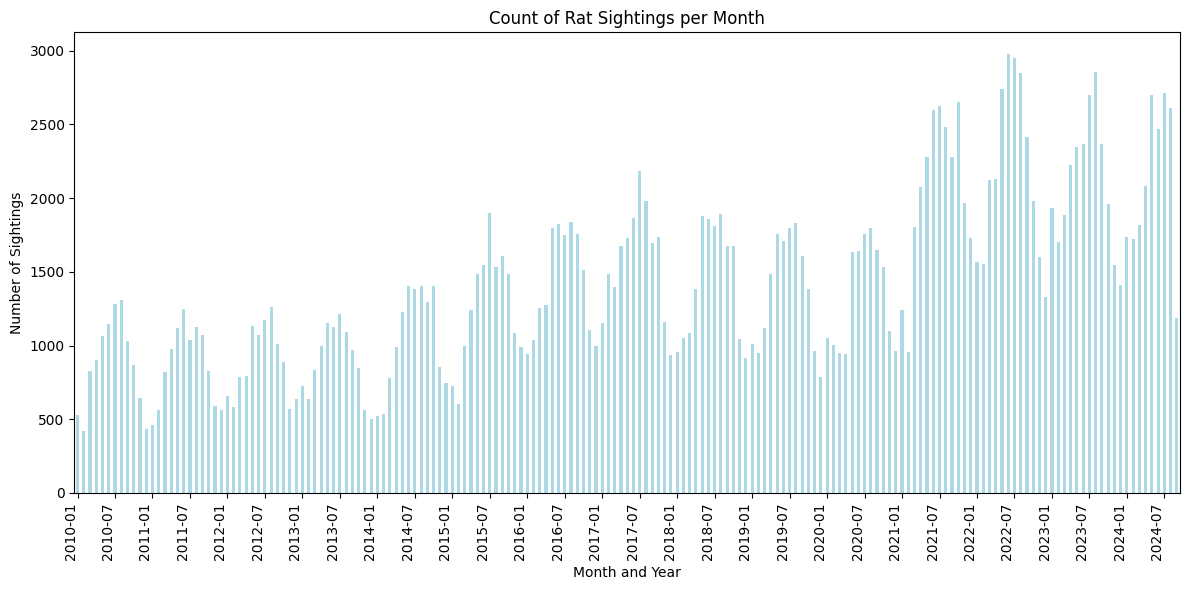

In [14]:
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Create a 'Year-Month' column as a datetime type, and then count occurrences
df['Year-Month'] = df['Created Date'].dt.to_period('M')  # 'M' ensures a Period type (year-month)
rat_sightings_by_month = df.groupby('Year-Month').size().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = rat_sightings_by_month.plot(kind='bar', color='lightblue')

# Limit the number of x-axis labels
xticks_to_show = rat_sightings_by_month.index[::6]
xtick_positions = range(0, len(rat_sightings_by_month), 6)

plt.xticks(ticks=xtick_positions, labels=xticks_to_show.astype(str), ha='right')

plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month and Year')
plt.ylabel('Number of Sightings')

plt.tight_layout()  # Ensures everything fits without overlap
plt.show()

Next, we will cut this up into quantiles and identify Low/Medium/High value for rat sighting based on time.

In [15]:
quantiles = pd.qcut(rat_sightings_by_month, 3, labels=["Low", "Medium", "High"])
quantiles

rat_sightings_by_month_category = quantiles

category_mapping = rat_sightings_by_month_category.to_dict()

df['Rat Concentration'] = df['Year-Month'].map(category_mapping)

### **TEST 1:** T-test on Summer vs Winter Rat Sightings


H0: There is no significant difference in rat sightings between winter months and summer months.

H1: There is a significant difference in rat sightings between winter months and summer months.

In [16]:
# Compare rat sightings between Winter (Dec-Feb) and Summer (Jun-Aug)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Get sightings for winter and summer
winter_sightings = df[df['Month'].isin(winter_months)]['Month'].count()
summer_sightings = df[df['Month'].isin(summer_months)]['Month'].count()

# Filter the data for winter and summer months
winter_data = df[df['Month'].isin([12, 1, 2])]
summer_data = df[df['Month'].isin([6, 7, 8])]


In [17]:
# Check the length of data for both groups
print("Winter sightings count:", len(winter_data))
print("Summer sightings count:", len(summer_data))

Winter sightings count: 42933
Summer sightings count: 82968


In [18]:
# Check for NaN values in these groups
print("NaN in winter data:", winter_data.isna().sum())
print("NaN in summer data:", summer_data.isna().sum())

# Drop rows with missing values in 'Incident Zip', 'Latitude', or 'Longitude'
winter_data_clean = winter_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])
summer_data_clean = summer_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])

# Check cleaned data
print("Cleaned winter data count:", len(winter_data_clean))
print("Cleaned summer data count:", len(summer_data_clean))

NaN in winter data: Created Date         0
Location Type        0
Incident Zip         0
Community Board      0
Borough              0
Latitude             0
Longitude            0
Month                0
Week                 0
Day                  0
Year-Month           0
Rat Concentration    0
dtype: int64
NaN in summer data: Created Date         0
Location Type        0
Incident Zip         0
Community Board      0
Borough              0
Latitude             0
Longitude            0
Month                0
Week                 0
Day                  0
Year-Month           0
Rat Concentration    0
dtype: int64
Cleaned winter data count: 42933
Cleaned summer data count: 82968


T test: T-test is only valid if the sample size is normally distributed and independent. By the Central Limit theorem, since the sizes of both datasets are over 30, a normal distribution can be assumed.

In [19]:
# Count the number of sightings per day in both seasons
winter_sightings_per_day = winter_data_clean['Created Date'].dt.date.value_counts()
summer_sightings_per_day = summer_data_clean['Created Date'].dt.date.value_counts()

# Perform the t-test comparing the number of sightings per day in winter vs summer
t_stat, p_value = stats.ttest_ind(winter_sightings_per_day, summer_sightings_per_day, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -32.5198022279798, P-value: 2.2052905701576025e-193


The T-test results in a p-value of approximately 1.70e-191. Thus, we reject our null hypothesis of no significant difference between Summer and Winter months. This extremely low p-value indicates a highly significant difference in the number of rat sightings between winter and summer. This supports the conclusion that rat sightings are substantially more prevalent during the summer months compared to winter. The results highlight the importance of seasonal factors in understanding rat populations and could inform pest management strategies.


**Insights: Correlation 1** - In examining the dataset of rat sightings, it becomes evident that there is a noticeable correlation between the number of rat sightings and the seasons, particularly when comparing warmer months to colder months. The data and graph indicates that rat sightings tend to increase significantly during the warmer months of summer (June, July, and August). This trend can be attributed to several factors, including increased outdoor activity, which leads to more people being in public spaces and consequently more reports of rat sightings. Additionally, the summer months typically provide a greater abundance of food sources for rats, whether through discarded food in parks and streets or increased human activity in residential areas. Conversely, there is a decline in rat sightings during the winter months (December, January, and February), which can be explained by harsh weather conditions that limit rat activity and their ability to forage for food. Moreover, rats may seek shelter in warmer environments during the winter, such as basements or other protected areas, making them less visible or accessible to the public.


## Part 4: Rat Sightings and Location

### **Test 2**: ANOVA Test on Rat Sightings across Boroughs

The ANOVA test is used to assess if there are significant differences in average rat sightings per zip code across different boroughs. Its purpose is to compare the means of multiple groups.

H0: There are no significant differences in mean rat sightings across boroughs

H1: There are significant differences in mean rat sightings across boroughs

In [20]:
from scipy import stats

sightings_per_zip = df.groupby(['Borough', 'Incident Zip']).size().reset_index(name='Sightings')

# group by Borough to prepare for ANOVA
sightings_by_borough = sightings_per_zip.groupby('Borough')['Sightings'].apply(list).reset_index()
print(sightings_by_borough)

# Extracting sightings lists for each borough
borough_groups = sightings_by_borough['Sightings'].tolist()

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*borough_groups)

print(f'P-value: {p_value}')

         Borough                                          Sightings
0          BRONX  [1797, 2525, 2655, 1300, 1848, 3660, 3131, 322...
1       BROOKLYN  [1996, 2260, 739, 2730, 3726, 3810, 2329, 1473...
2      MANHATTAN  [26, 8, 919, 2493, 1711, 103, 107, 165, 416, 2...
3         QUEENS  [91, 66, 17, 1401, 797, 1199, 777, 1239, 872, ...
4  STATEN ISLAND  [1031, 592, 642, 825, 900, 1208, 181, 591, 420...
P-value: 1.6924366973020327e-09


We Reject the null hypothesis (H0) because the p-value of 1.685e-9 is far less than the alpha value of 0.05. This indicates that there are significant difference in rat sightings across boroughs. However, a post-hoc test is necessary to identify which boroughs have more significant differences. For this, we use Turkey HSD post-hoc test to identify significant differences.

But first, let's visualize the results of the ANOVA Test.

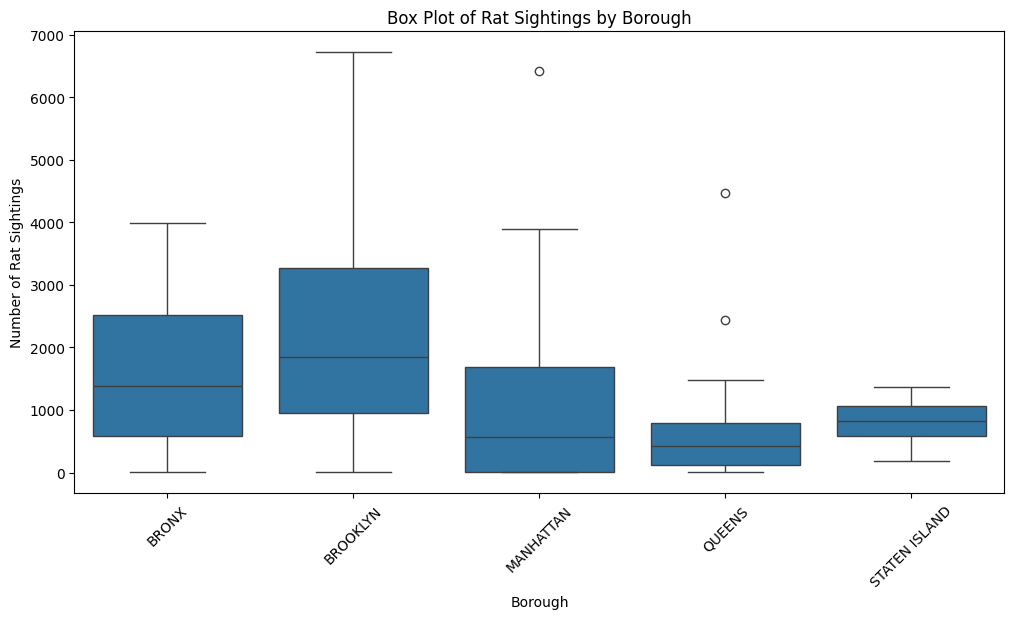

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Borough', y='Sightings', data=sightings_per_zip)
plt.title('Box Plot of Rat Sightings by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rat Sightings')
plt.xticks(rotation=45)
plt.show()


### **Follow-up** Post-hoc Test with Turkey's HSD Test



In [22]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

long_df = sightings_per_zip[['Borough', 'Sightings']].copy()
long_df = long_df.explode('Sightings').reset_index(drop=True)
long_df['Sightings'] = pd.to_numeric(long_df['Sightings'], errors='coerce')

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(long_df['Sightings'], long_df['Borough'], alpha=0.05)
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1      group2     meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
    BRONX      BROOKLYN   636.7036  0.184  -159.8551 1433.2623  False
    BRONX     MANHATTAN  -570.5648 0.2089 -1305.5915  164.4619  False
    BRONX        QUEENS  -975.3527  0.003 -1710.3793  -240.326   True
    BRONX STATEN ISLAND  -743.2011 0.3729 -1875.6395  389.2372  False
 BROOKLYN     MANHATTAN -1207.2684    0.0 -1858.4881 -556.0487   True
 BROOKLYN        QUEENS -1612.0563    0.0  -2263.276 -960.8366   True
 BROOKLYN STATEN ISLAND -1379.9048 0.0048 -2459.8305 -299.9791   True
MANHATTAN        QUEENS  -404.7879 0.2999  -979.1097  169.5339  False
MANHATTAN STATEN ISLAND  -172.6364 0.9908 -1208.0097   862.737  False
   QUEENS STATEN ISLAND   232.1515 0.9723  -803.2218 1267.5248  False
---------------------------------------------------------------------


The results suggest that Brooklyn has significantly lower rat sightings compared to boroughs such as Manhattan, Queens, and Staten Island.

The results do not suggest significant differences in sightings between Bronx and Brooklyn, or between some other borough pairs.


One consideration to make is the size  of respective regions when interpreting these results. It would be important to incorporate this data to determine concentration of rat sightings when performing analysis within our final findings.

## Part 5: Rat Sightings in Residential vs. Non-Residential Properties

### **Test 3:** Mann-Whitney Test on Residential vs. Non-Residential Rat Sightings

In [23]:
from scipy.stats import mannwhitneyu

residential_sightings = residential_df['Incident Zip'].value_counts()
non_residential_sightings = nonresidential_df['Incident Zip'].value_counts()

# Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(residential_sightings, non_residential_sightings, alternative='two-sided')

# Output results
print(f'Mann-Whitney U Statistic: {u_stat}, P-value: {p_value}')

Mann-Whitney U Statistic: 29047.0, P-value: 5.084196762032582e-22


As the p-value of 5.245e-22 is less than the significance level, alpha = 0.05, we reject the Null Hypothesis (H₀) that the distribution of rat sightings in residential areas is equal to that in non-residential areas. This proves that we have statistically significant evidence to conclude in favor of the alternative hypothesis that the distribution of rat sightings in residential areas is not equal to that in non-residential areas.

#### Visualization

We can also visualize the results from the Mann-Whitney Test using a bar graph:

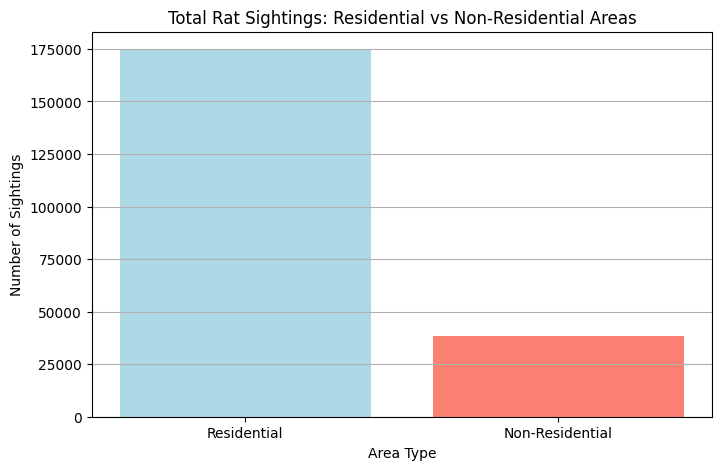

In [24]:
# Visualization
counts = pd.DataFrame({
    'Area Type': ['Residential', 'Non-Residential'],
    'Sightings': [residential_sightings.sum(), non_residential_sightings.sum()]
})

plt.figure(figsize=(8, 5))
plt.bar(counts['Area Type'], counts['Sightings'], color=['lightblue', 'salmon'])
plt.title('Total Rat Sightings: Residential vs Non-Residential Areas')
plt.xlabel('Area Type')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Merging Income & Rat Sightings Dataset

In [25]:
df = pd.read_csv("Rat_Sightings_20240917.csv", low_memory=False)

# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]

# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']
df.reset_index(drop=True, inplace=True)

# Drop NAs
df.dropna(subset=['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude'], inplace=True)

# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()

# Define mapping for residential categories
residential_mapping = {
    'Single Room Occupancy (SRO)': 'Single',
    '1-2 Family Dwelling': '1-2 Family Apartment',
    '1-2 FamilyDwelling': '1-2 Family Apartment',
    '3+ Family Apt. Building': '3+ Family',
    '3+ Family Apartment Building': '3+ Family',
    '3+ Family Apt.': '3+ Family',
    '3+Family Apt.': '3+ Family',
    '3+ Family Apt': '3+ Family',
    '1-3 Family Dwelling': '1-3 Family Dwelling',
    '1-3 Family Mixed Use Building': '1-3 Family Mixed',
    '1-2 Family Mixed Use Building': '1-2 Family Mixed',
    '3+ Family Mixed Use Building': '3+ Family Mixed',
    'Private House': 'Private House',
    'Apartment': 'Apartment',
    'Residential Property': 'Residential Property'
}

# Apply mapping to the 'Location Type' column for residential data
df['Location Type'] = df['Location Type'].replace(residential_mapping)

In [26]:
# Income data df, zipcodes for NYC boroughs, and rat sightings df
income_df = pd.read_csv("us_income_zipcode.csv")
zipcode_borough = pd.read_csv("New_York_State_ZIP_Codes-County_FIPS_Cross-Reference.csv")

In [27]:
### Dropping all margin of error columns
def drop_margin_cols():
    lst = income_df.columns
    remove_list = []

    for col in lst:
        if "Margin of Error" in col:
            remove_list.append(col)
    return remove_list

lst = drop_margin_cols()
income_df.drop(lst, axis=1, inplace=True)

#Dropping other useless columns
income_df.drop(["Geography", "Geographic Area Name"], axis=1, inplace=True)
income_df

#Dropping columns we don't need from borough df
zipcode_borough.drop(["State FIPS", "County Code", "File Date", "County FIPS"], axis=1, inplace=True)
zipcode_borough

,County Name,ZIP Code
0,Albany,12007
1,Albany,12009
2,Albany,12023
3,Albany,12041
4,Albany,12045
...,...,...
2538,Yates,14561
2539,Yates,14837
2540,Yates,14842
2541,Yates,14857


In [28]:
#Merging income_df and zipcode_borough
merged_df = income_df.merge(zipcode_borough, left_on="ZIP", right_on="ZIP Code")

#Filtering to only the 5 boroughs of NYC
merged_df = merged_df[(merged_df["County Name"] == "Bronx") | (merged_df["County Name"] == "Queens") | (merged_df["County Name"] == "New York") | (merged_df["County Name"] == "Kings") | (merged_df["County Name"] == "Richmond")]

#Dropping ZIP Code cause we don't need it (redundant column)
merged_df.drop("ZIP Code", axis=1, inplace=True)

#Fixing year to make it an int
merged_df["Year"] = merged_df["Year"].astype(int)

#Fixing households to make them ints
merged_df["Households"] = merged_df["Households"].astype(int)

#No more NA values!!!
merged_df.dropna()
merged_df

,ZIP,Households,"Households Less Than $10,000","Households $10,000 to $14,999","Households $15,000 to $24,999","Households $25,000 to $34,999","Households $35,000 to $49,999","Households $50,000 to $74,999","Households $75,000 to $99,999","Households $100,000 to $149,999",...,"Nonfamily Households $50,000 to $74,999","Nonfamily Households $75,000 to $99,999","Nonfamily Households $100,000 to $149,999","Nonfamily Households $150,000 to $199,999","Nonfamily Households $200,000 or More",Nonfamily Households Median Income (Dollars),Nonfamily Households Mean Income (Dollars),Nonfamily Households Nonfamily Income in the Past 12 Months,Year,County Name
1,10001,14273,7.2,3.4,5.4,3.3,7.4,11.5,11.2,14.9,...,12.2,13.0,15.7,11.4,19.0,89723.0,131592.0,20.1,2021,New York
2,10002,34737,13.0,11.8,12.9,10.0,9.1,11.2,9.2,9.2,...,10.0,9.4,10.1,4.3,8.0,32489.0,69003.0,34.8,2021,New York
3,10003,25181,6.8,2.2,3.3,4.3,4.2,11.9,6.9,13.3,...,14.7,7.6,14.2,10.7,27.7,105808.0,175535.0,28.5,2021,New York
4,10004,2113,2.2,0.0,0.9,1.6,0.4,2.0,6.1,13.5,...,3.1,10.6,19.9,21.0,38.7,159518.0,218597.0,25.7,2021,New York
5,10005,4782,0.9,0.0,0.1,1.4,2.1,9.2,6.1,15.2,...,11.7,5.0,17.2,18.4,41.4,185125.0,198121.0,21.7,2021,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22134,11692,5830,14.6,8.0,9.2,16.0,11.7,17.1,8.5,10.3,...,14.9,7.9,5.3,0.3,1.2,25617.0,39178.0,40.4,2011,Queens
22135,11693,4583,12.3,4.6,7.6,7.8,17.6,16.1,14.8,15.4,...,16.3,10.2,5.9,1.6,2.6,40742.0,57435.0,46.1,2011,Kings
22136,11693,4583,12.3,4.6,7.6,7.8,17.6,16.1,14.8,15.4,...,16.3,10.2,5.9,1.6,2.6,40742.0,57435.0,46.1,2011,Queens
22137,11694,8135,4.9,4.2,8.1,10.3,9.3,14.3,11.6,20.3,...,16.4,10.9,11.4,0.4,1.7,37194.0,52125.0,47.7,2011,Queens


In [29]:
#Merging income with the rat sightings data
income_rat_df = merged_df.merge(df, left_on="ZIP", right_on="Incident Zip")

# A function to keep only the important columns and mean/median income columns for final dataframe
def save_cols():
    columns = income_rat_df.columns
    save_lst = []
    important = ["ZIP", "Households", "Year", "Created Date", "Location Type", "Community Board", "Borough", "Latitude", "Longitude"]

    for col in columns:
        if "Mean Income (Dollars)" in col or "Median Income (Dollars)" in col:
            save_lst.append(col)
        elif col in important:
            save_lst.append(col)

    return save_lst

lst = save_cols()
income_rat_df = income_rat_df[lst]
income_rat_df.dropna(inplace=True)
income_rat_df
#print(income_rat_df.columns)

,ZIP,Households,Households Median Income (Dollars),Households Mean Income (Dollars),Families Median Income (Dollars),Families Mean Income (Dollars),Married-Couple Families Median Income (Dollars),Married-Couple Families Mean Income (Dollars),Nonfamily Households Median Income (Dollars),Nonfamily Households Mean Income (Dollars),Year,Created Date,Location Type,Community Board,Borough,Latitude,Longitude
919,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,5/16/2024 11:19,3+ Family,03 MANHATTAN,MANHATTAN,40.712894,-73.996101
920,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,8/31/2024 20:15,Commercial Building,03 MANHATTAN,MANHATTAN,40.712995,-73.988529
921,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,8/15/2024 5:24,3+ Family,03 MANHATTAN,MANHATTAN,40.712353,-73.993947
922,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,6/4/2024 20:19,Office Building,03 MANHATTAN,MANHATTAN,40.722009,-73.993376
923,10002,34737,37093.0,76115.0,38815.0,82382.0,51689.0,101513.0,32489.0,69003.0,2021,5/8/2024 17:31,3+ Family,03 MANHATTAN,MANHATTAN,40.716111,-73.992998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790230,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,4/26/2024 17:54,1-2 Family Apartment,08 QUEENS,QUEENS,40.711187,-73.810153
2790231,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,5/1/2024 13:05,1-2 Family Apartment,12 QUEENS,QUEENS,40.687113,-73.799311
2790232,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,5/2/2024 20:37,Commercial Building,12 QUEENS,QUEENS,40.701386,-73.804111
2790233,11435,17950,54086.0,65131.0,57789.0,70488.0,67135.0,78335.0,39375.0,51434.0,2011,5/4/2024 18:17,1-2 Family Apartment,12 QUEENS,QUEENS,40.694572,-73.809710


We want to create a single column that gives us the average income in an area. We currently have two measures of center for the income: median and mean. As mean is dramatically influenced by skew, we decided to procede with the median as our main measure of average income.

In [30]:
# List of median income columns
median_income_columns = [
    'Households Median Income (Dollars)',
    'Families Median Income (Dollars)',
    'Married-Couple Families Median Income (Dollars)',
    'Nonfamily Households Median Income (Dollars)'
]

# Calculate the average of the median income columns
income_rat_df['Average Income (Dollars)'] = income_rat_df[median_income_columns].mean(axis=1)

# Drop the original mean and median columns
columns_to_drop = [
    'Households Median Income (Dollars)',
    'Households Mean Income (Dollars)',
    'Families Median Income (Dollars)',
    'Families Mean Income (Dollars)',
    'Married-Couple Families Median Income (Dollars)',
    'Married-Couple Families Mean Income (Dollars)',
    'Nonfamily Households Median Income (Dollars)',
    'Nonfamily Households Mean Income (Dollars)'
]

income_rat_df = income_rat_df.drop(columns=columns_to_drop)

income_rat_df

,ZIP,Households,Year,Created Date,Location Type,Community Board,Borough,Latitude,Longitude,Average Income (Dollars)
919,10002,34737,2021,5/16/2024 11:19,3+ Family,03 MANHATTAN,MANHATTAN,40.712894,-73.996101,40021.50
920,10002,34737,2021,8/31/2024 20:15,Commercial Building,03 MANHATTAN,MANHATTAN,40.712995,-73.988529,40021.50
921,10002,34737,2021,8/15/2024 5:24,3+ Family,03 MANHATTAN,MANHATTAN,40.712353,-73.993947,40021.50
922,10002,34737,2021,6/4/2024 20:19,Office Building,03 MANHATTAN,MANHATTAN,40.722009,-73.993376,40021.50
923,10002,34737,2021,5/8/2024 17:31,3+ Family,03 MANHATTAN,MANHATTAN,40.716111,-73.992998,40021.50
...,...,...,...,...,...,...,...,...,...,...
2790230,11435,17950,2011,4/26/2024 17:54,1-2 Family Apartment,08 QUEENS,QUEENS,40.711187,-73.810153,54596.25
2790231,11435,17950,2011,5/1/2024 13:05,1-2 Family Apartment,12 QUEENS,QUEENS,40.687113,-73.799311,54596.25
2790232,11435,17950,2011,5/2/2024 20:37,Commercial Building,12 QUEENS,QUEENS,40.701386,-73.804111,54596.25
2790233,11435,17950,2011,5/4/2024 18:17,1-2 Family Apartment,12 QUEENS,QUEENS,40.694572,-73.809710,54596.25


In [31]:
# Convert 'Created Date' to datetime format
income_rat_df['Created Date'] = pd.to_datetime(income_rat_df['Created Date'])

# Extract month, week, and day information
income_rat_df['Month'] = income_rat_df['Created Date'].dt.month

# Check the updated dataframe
print(income_rat_df[['Created Date', 'Month']].head())

income_rat_df['Year-Month'] = income_rat_df['Created Date'].dt.strftime('%B %Y')
rat_sightings_by_month = income_rat_df['Year-Month'].value_counts().sort_index()

           Created Date  Month
919 2024-05-16 11:19:00      5
920 2024-08-31 20:15:00      8
921 2024-08-15 05:24:00      8
922 2024-06-04 20:19:00      6
923 2024-05-08 17:31:00      5


## Part 8: Conclusion

Our analysis explored rat sightings across New York City across the years 2011-2021, investigating the impact of geographic location, income levels, and population density. The goal of this analysis was to identify significant patterns in rat sightings that could better inform public health strategies and urban planning.

We began our analysis by examining the geographic distribution of rat sightings across the city’s boroughs. An ANOVA test revealed significant differences in the number of sightings between boroughs. Manhattan and Staten Island experienced notably higher rat sightings, while Brooklyn had significantly fewer. However, some boroughs, like the Bronx and Brooklyn, did not show statistically significant differences in rat sighting counts. These findings suggest that geography plays a role in rat infestations, but other factors, such as population density and socioeconomic conditions, may also be contributing to these patterns.

In addition to the geographic analysis, we compared rat sightings in residential and non-residential areas using the Mann-Whitney U test. The results indicated a significant difference, with residential areas reporting more rat sightings than non-residential ones. This points to a potential public health concern, as rats in residential areas may pose more direct risks to human health. These findings emphasize the importance of focusing on residential infestations when implementing pest control measures and public health interventions.

Further analysis was conducted by merging rat sighting data with U.S. Census income data to investigate the relationship between income and rat infestations. A chi-squared test showed that wealthier boroughs tend to have more families with median incomes above $100,000, highlighting the economic disparities across the city. Although this test did not directly link income to rat sightings, it provides a basis for future research into whether wealthier areas experience fewer rat infestations due to better infrastructure and services. The relationship between income levels and the frequency of rat sightings warrants further exploration.

Finally, we examined the correlation between population density and rat sightings. The Pearson correlation coefficient indicated a weak positive relationship between the two variables, suggesting that while rat sightings tend to increase with population density, the correlation is not strong. This analysis also revealed a bell-curve pattern, implying that other factors, such as urban infrastructure and waste management, may be more influential than population density alone in determining the prevalence of rats.

In summary, our research highlights the multifaceted nature of rat infestations in New York City. As geographic location, residential versus non-residential areas, and socioeconomic factors all contribute to the distribution of rat sightings, we made sure to find accurate and reliable datasets and manipulated them to better analyze the impact of rat infestations on public hygiene and general human health. While population density shows a weak correlation with sightings, other underlying factors likely play a role in the occurrence of rats. In the future, we plan to include population density or physical square footage when comparing boroughs to gain more accurate insights. Additionally, we will analyze income ranges and examine the correlation coefficients across various categories to identify key patterns. We'll also investigate how income levels correspond with reported sightings. Finally, we will merge all of our datasets to conduct a comprehensive analysis and uncover deeper relationships between these variables.

# Primary analysis & ML Model

insert analysis of EDA here & decision on ML model

In [32]:
quantiles = pd.qcut(rat_sightings_by_month, 3, labels=["Low", "Medium", "High"])
rat_sightings_by_month_category = quantiles
category_mapping = rat_sightings_by_month_category.to_dict()

income_rat_df['Rat Concentration'] = income_rat_df['Year-Month'].map(category_mapping)
income_rat_df.drop("Created Date", axis=1, inplace=True)
income_rat_df.drop("Year", axis=1, inplace=True)

income_rat_df

,ZIP,Households,Location Type,Community Board,Borough,Latitude,Longitude,Average Income (Dollars),Month,Year-Month,Rat Concentration
919,10002,34737,3+ Family,03 MANHATTAN,MANHATTAN,40.712894,-73.996101,40021.50,5,May 2024,High
920,10002,34737,Commercial Building,03 MANHATTAN,MANHATTAN,40.712995,-73.988529,40021.50,8,August 2024,High
921,10002,34737,3+ Family,03 MANHATTAN,MANHATTAN,40.712353,-73.993947,40021.50,8,August 2024,High
922,10002,34737,Office Building,03 MANHATTAN,MANHATTAN,40.722009,-73.993376,40021.50,6,June 2024,High
923,10002,34737,3+ Family,03 MANHATTAN,MANHATTAN,40.716111,-73.992998,40021.50,5,May 2024,High
...,...,...,...,...,...,...,...,...,...,...,...
2790230,11435,17950,1-2 Family Apartment,08 QUEENS,QUEENS,40.711187,-73.810153,54596.25,4,April 2024,High
2790231,11435,17950,1-2 Family Apartment,12 QUEENS,QUEENS,40.687113,-73.799311,54596.25,5,May 2024,High
2790232,11435,17950,Commercial Building,12 QUEENS,QUEENS,40.701386,-73.804111,54596.25,5,May 2024,High
2790233,11435,17950,1-2 Family Apartment,12 QUEENS,QUEENS,40.694572,-73.809710,54596.25,5,May 2024,High


In [33]:
# Count the number of rows for each value in the "Rat Concentration" column
rat_concentration_counts = income_rat_df['Rat Concentration'].value_counts()

# Print the counts for each value
print(rat_concentration_counts)

Rat Concentration
High      481186
Medium    307325
Low       188691
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.74      0.76     96238
         Low       0.52      0.60      0.56     37738
      Medium       0.61      0.59      0.60     61465

    accuracy                           0.67    195441
   macro avg       0.64      0.65      0.64    195441
weighted avg       0.67      0.67      0.67    195441



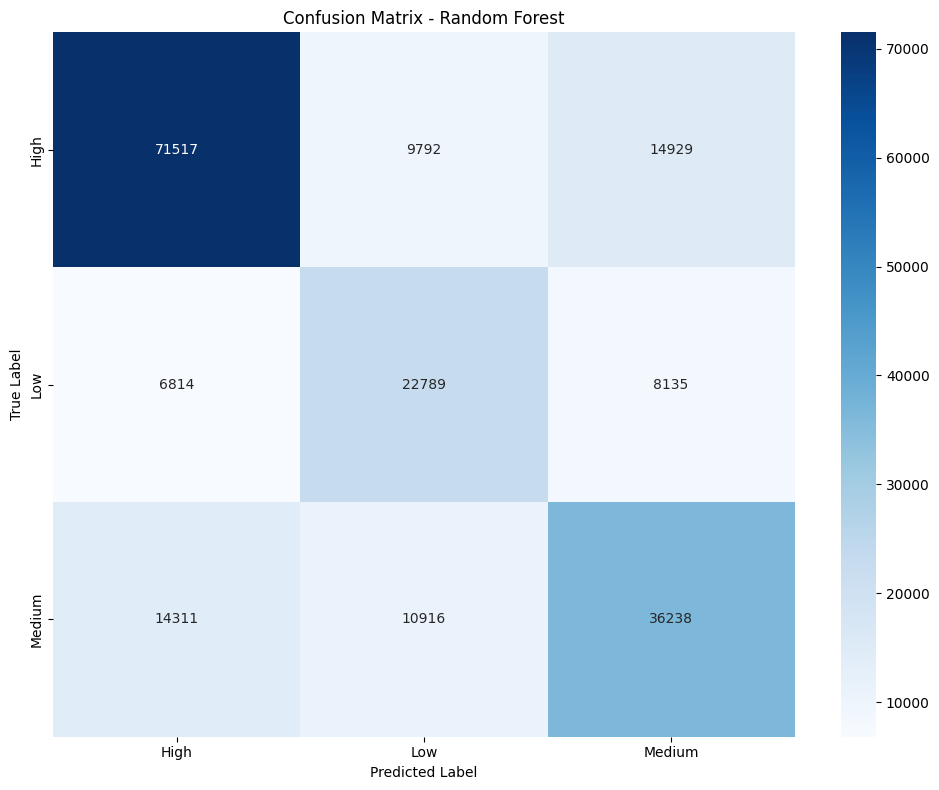


Feature Importances:
                    Feature  Importance
0                  Latitude    0.461845
1                 Longitude    0.449676
3                Households    0.045710
2  Average Income (Dollars)    0.042769


<ipython-input-35-14087306c2d7>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


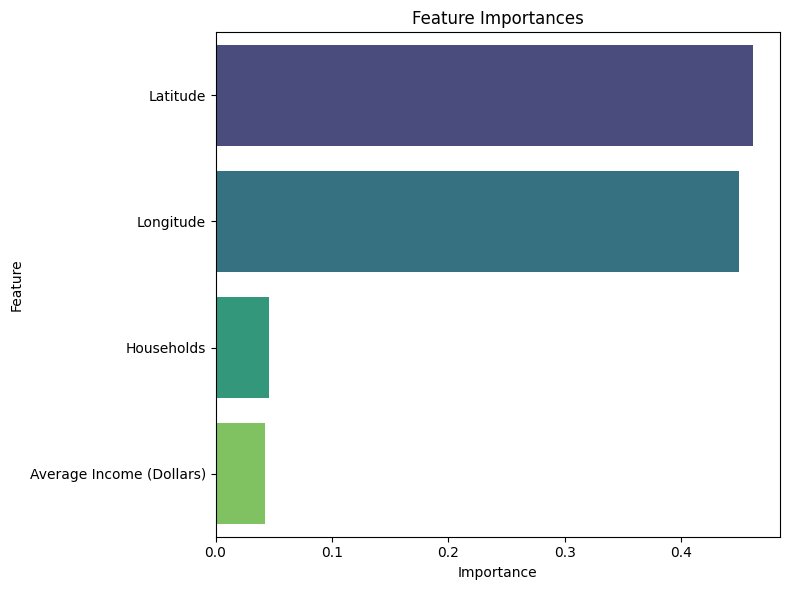

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to train and evaluate a Random Forest model
def train_random_forest_model(income_rat_df):
    # Select features and target variable
    features = ['Latitude', 'Longitude', 'Average Income (Dollars)', 'Households']
    target = 'Rat Concentration'
    X = income_rat_df[features]
    y = income_rat_df[target]

    # Encode the target variable if necessary
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = y.astype('category').cat.codes  # Converts high/medium/low to integers

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees
        class_weight='balanced',  # Handles class imbalances automatically
        random_state=42
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['High', 'Low', 'Medium']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['High', 'Low', 'Medium'],
                yticklabels=['High', 'Low', 'Medium'])
    plt.title('Confusion Matrix - Random Forest')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Feature Importance
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(feature_importance_df)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return rf_model

# Call the function
random_forest_model = train_random_forest_model(income_rat_df)

# ML Model Visualization

## Part 7 (Appendix): Number of Rat Sightings vs. Population Density By Zip Code

We also have a dataset of the population densities in New York City by zip code for 2024. We merge this data with the rat sightings data from 2024 to detect any linear correlation between the population density and the number of rat sightings reported.


In [36]:
import numpy as np

# Get population density dataset
pop_density_df = pd.read_csv("uszips.csv")
pop_density_df = pop_density_df[['zip', 'density']]

# Filter on 2024 data
pop_merged_df = pd.merge(pop_density_df, df[df['Created Date'].dt.year == 2024], left_on='zip', right_on='ZIP', how='inner')

# Get number of sightings per zip code, keeping numerical order of zip
groups = pop_merged_df.groupby('zip', as_index=False)
num_sightings = groups.size().sort_values('zip', ascending=True)

# Get unique list of zip codes in numerical order
pop_merged_df.sort_values('zip', ascending=True, inplace=True)
zips = pop_merged_df['zip'].unique()

# Get corresponding densities of the ordered zips
pop_merged_df = pop_merged_df.drop_duplicates(subset='zip', keep="first").sort_values('zip', ascending=True)

x = pop_merged_df['density']
y = num_sightings['size']
# print(len(x)) # number of data points in our scatterplot

# Pearson correlation coefficient
print("Correlation Coefficient: " + str(np.corrcoef(x, y)[0, 1]))

AttributeError: Can only use .dt accessor with datetimelike values

The two datasets are merged on the zip code, and we find the number of sightings and the population density of each zip code, totaling 180 data points.

We find the Pearson correlation coefficient to be 0.291, indicating a weak positive linear correlation between population density and number of rat sightings. We can conclude that the number of rat sightings does not consistently linearly increase as the population density increases.

In [37]:
# Plot number of sightings vs. population density of zip
a, b = np.polyfit(x, y, 1)

plt.scatter(x, y, color='#faaba2')
plt.plot(x, a*x+b, color='#6eb9ff') # line of best fit
plt.xlabel("Density (Population Per Square Kilometer)")
plt.ylabel("Number of Rat Sightings")
plt.title("Number of Rat Sightings vs. Population Density By Zip Code")
plt.show()

NameError: name 'x' is not defined

This is a scatterplot with the population density on the x-axis and the number of rat sightings on the y-axis. We observe visually that the distribution has more of a bell-curve shape, which may be explained by the Central Limit Theorem acting upon other factors to produce a normal distribution.

In the future, we may attempt binning the data on a categorical variable, such as income ranges, to look for differing correlation coefficients.